In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import os
# Set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# do not prealocate memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [2]:
import matplotlib.pyplot as plt
import numpyro.distributions as dist
from jax.scipy import linalg
import jax.numpy as jnp
from jax import vmap, random as jr, nn

def exact_blr(X, y, lam=1., mu_0=0., a_0=2., b_0=1.):
    # bayesian linear regression
    n, D = X.shape

    mu_0 = mu_0 * jnp.ones(D)
    P_0  = jnp.diag(lam * jnp.ones(D))
    S = X.T @ X
    P_n = P_0 + S
    tmp = X.T @ y + P_0 @ mu_0
    mu_n = linalg.solve(P_n, tmp, assume_a='pos')

    a_n = a_0 + n / 2
    b_n = b_0 + (y.T @ y + mu_0.T @ P_0 @ mu_0 - mu_n.T @ tmp) / 2

    return mu_n, P_n, a_n, b_n

def generate_data_and_invert_model(key, L, N, D):
    key, _key = jr.split(key)
    X_norm = jr.normal(_key, shape=(N, D)) @ L

    y_norm = X_norm @ nn.one_hot(0, num_classes=D) + jr.normal(key, shape=(N,))

    # add bias
    X_norm = jnp.pad(X_norm, [(0, 0), (0, 1)], constant_values=1.)
    return exact_blr(X_norm, y_norm, lam=1, mu_0=0., a_0=2., b_0=1.)

def rmse(params, D):
    sigma_sqr = 1 / jnp.diagonal(params[1], axis1=-1, axis2=-2)
    return jnp.sqrt( jnp.square(nn.one_hot(0, num_classes=D + 1) - params[0]).sum(-1) + sigma_sqr.sum(-1) )

def ΔF_mv_gamma(mu, P, gamma_sqr, a, b):
    # Delta F for multivariate normal gamma posterior
    cho_p = linalg.cho_factor(P)
    G = jnp.diag(gamma_sqr)
    M = G + linalg.cho_solve( cho_p, jnp.diag((1 - gamma_sqr)) )

    lu_m = linalg.lu_factor(M)
    logdet = jnp.log(jnp.abs(jnp.diag(lu_m[0]))).sum()
    df = - logdet / 2 # - logdet|M| / 2

    t_P = P + jnp.diag(1/gamma_sqr - 1)
    _mu = P @ mu
    t_mu = G @ linalg.lu_solve(lu_m, mu)

    t_b = b + jnp.inner(mu - t_mu, _mu) / 2
    df += a * (jnp.log(b) - jnp.log(t_b))
    
    return df, t_mu, t_P, t_b

vfunc = vmap(generate_data_and_invert_model, in_axes=(0, None, None, None))

In [5]:
D = 2

L1 = jnp.array([[1., 0], [0., 1.]])
L2 = jnp.linalg.cholesky(jnp.array([[1., .5], [.5, 1.]]))
L3 = jnp.linalg.cholesky(jnp.array([[1., .75], [.75, 1.]]))
L4 = jnp.linalg.cholesky(jnp.array([[1., .95], [.95, 1.]]))
Ls = [L1, L2, L3, L4]

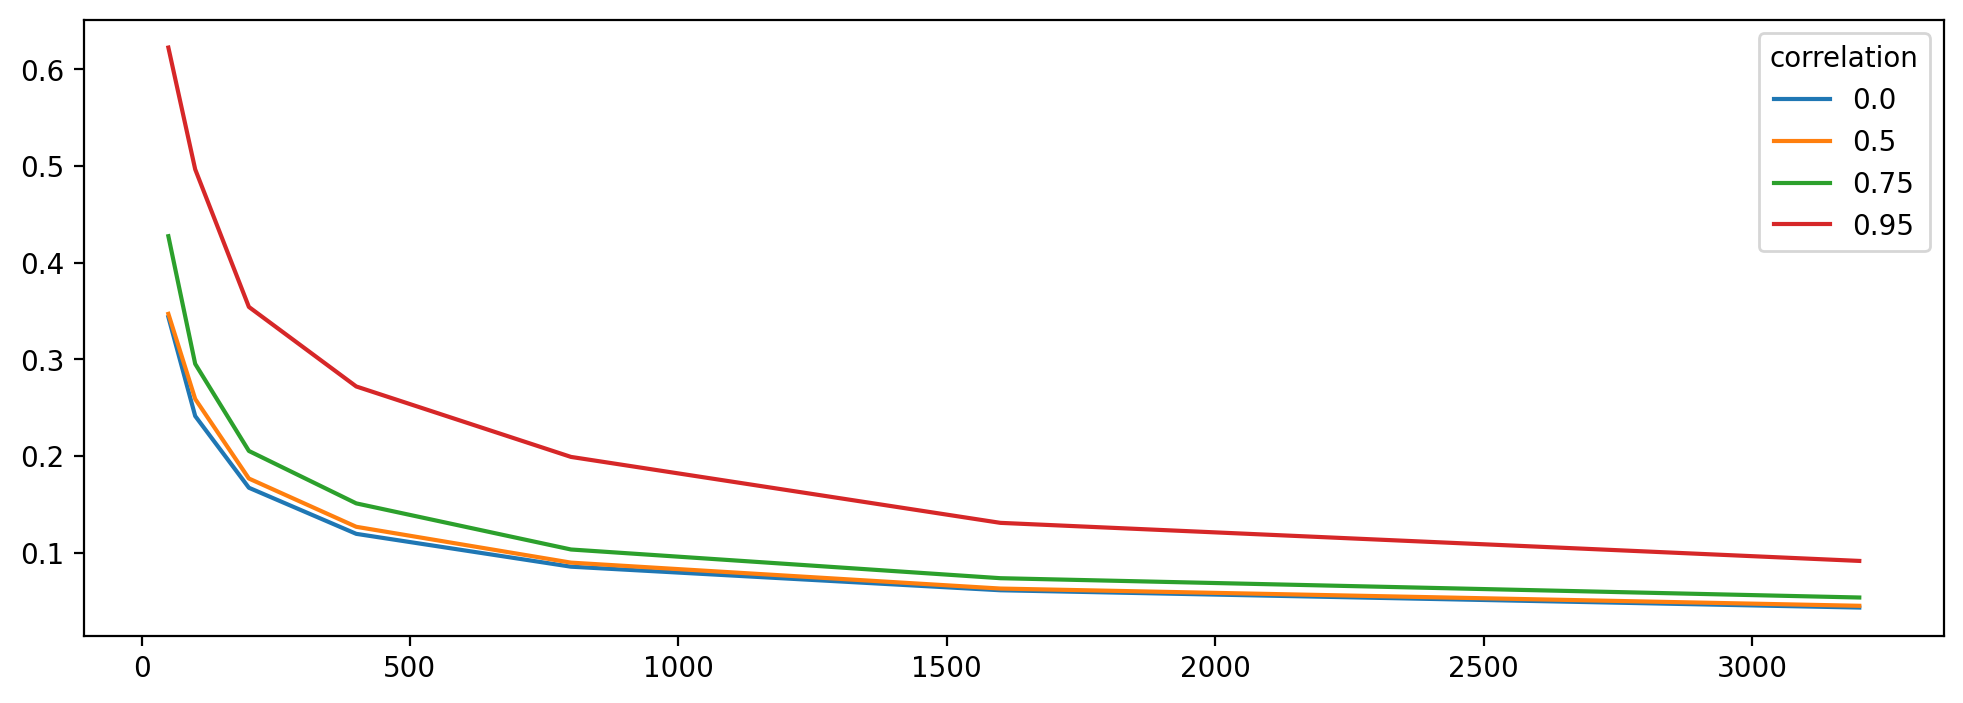

In [7]:
seed = 2982666625879488464
key = jr.PRNGKey(seed)

res = {}
for N in [50, 100, 200, 400, 800, 1600, 3200]:
    corrs = []
    for L in Ls:
        key, _key = jr.split(key)
        keys = jr.split(_key, 100)
        posterior = vfunc(keys, L, N, D)
        corrs.append( rmse(posterior, D) )
    res[N] = corrs

plt.figure(figsize=(12, 4))
for i in range(4):
    plt.plot([50, 100, 200, 400, 800, 1600, 3200], [res[key][i].mean() for key in res])
plt.legend([0., 0.5, 0.75, 0.95], title='correlation');

In [13]:
max_fitness = 0.
g_sqr = jnp.ones(D)
p = .5
for _ in range(8):
    c = jnp.log(p) - jnp.log(1-p)
    for idx in range(D):
        if g_sqr[idx] == 1:
            _g = g_sqr.at[idx].set(0.)
            ftns, mu_t, P_t, b_t = ΔF_mv(mu=mu_n, P=P_n, gamma_sqr=_g, a=a_n, b=b_n)
            df = max_fitness - ftns + c
            if df <= 0:
                max_fitness = ftns
                g_sqr = _g 

    a = g_sqr.sum()
    p = (a + .5) / (D + 1)

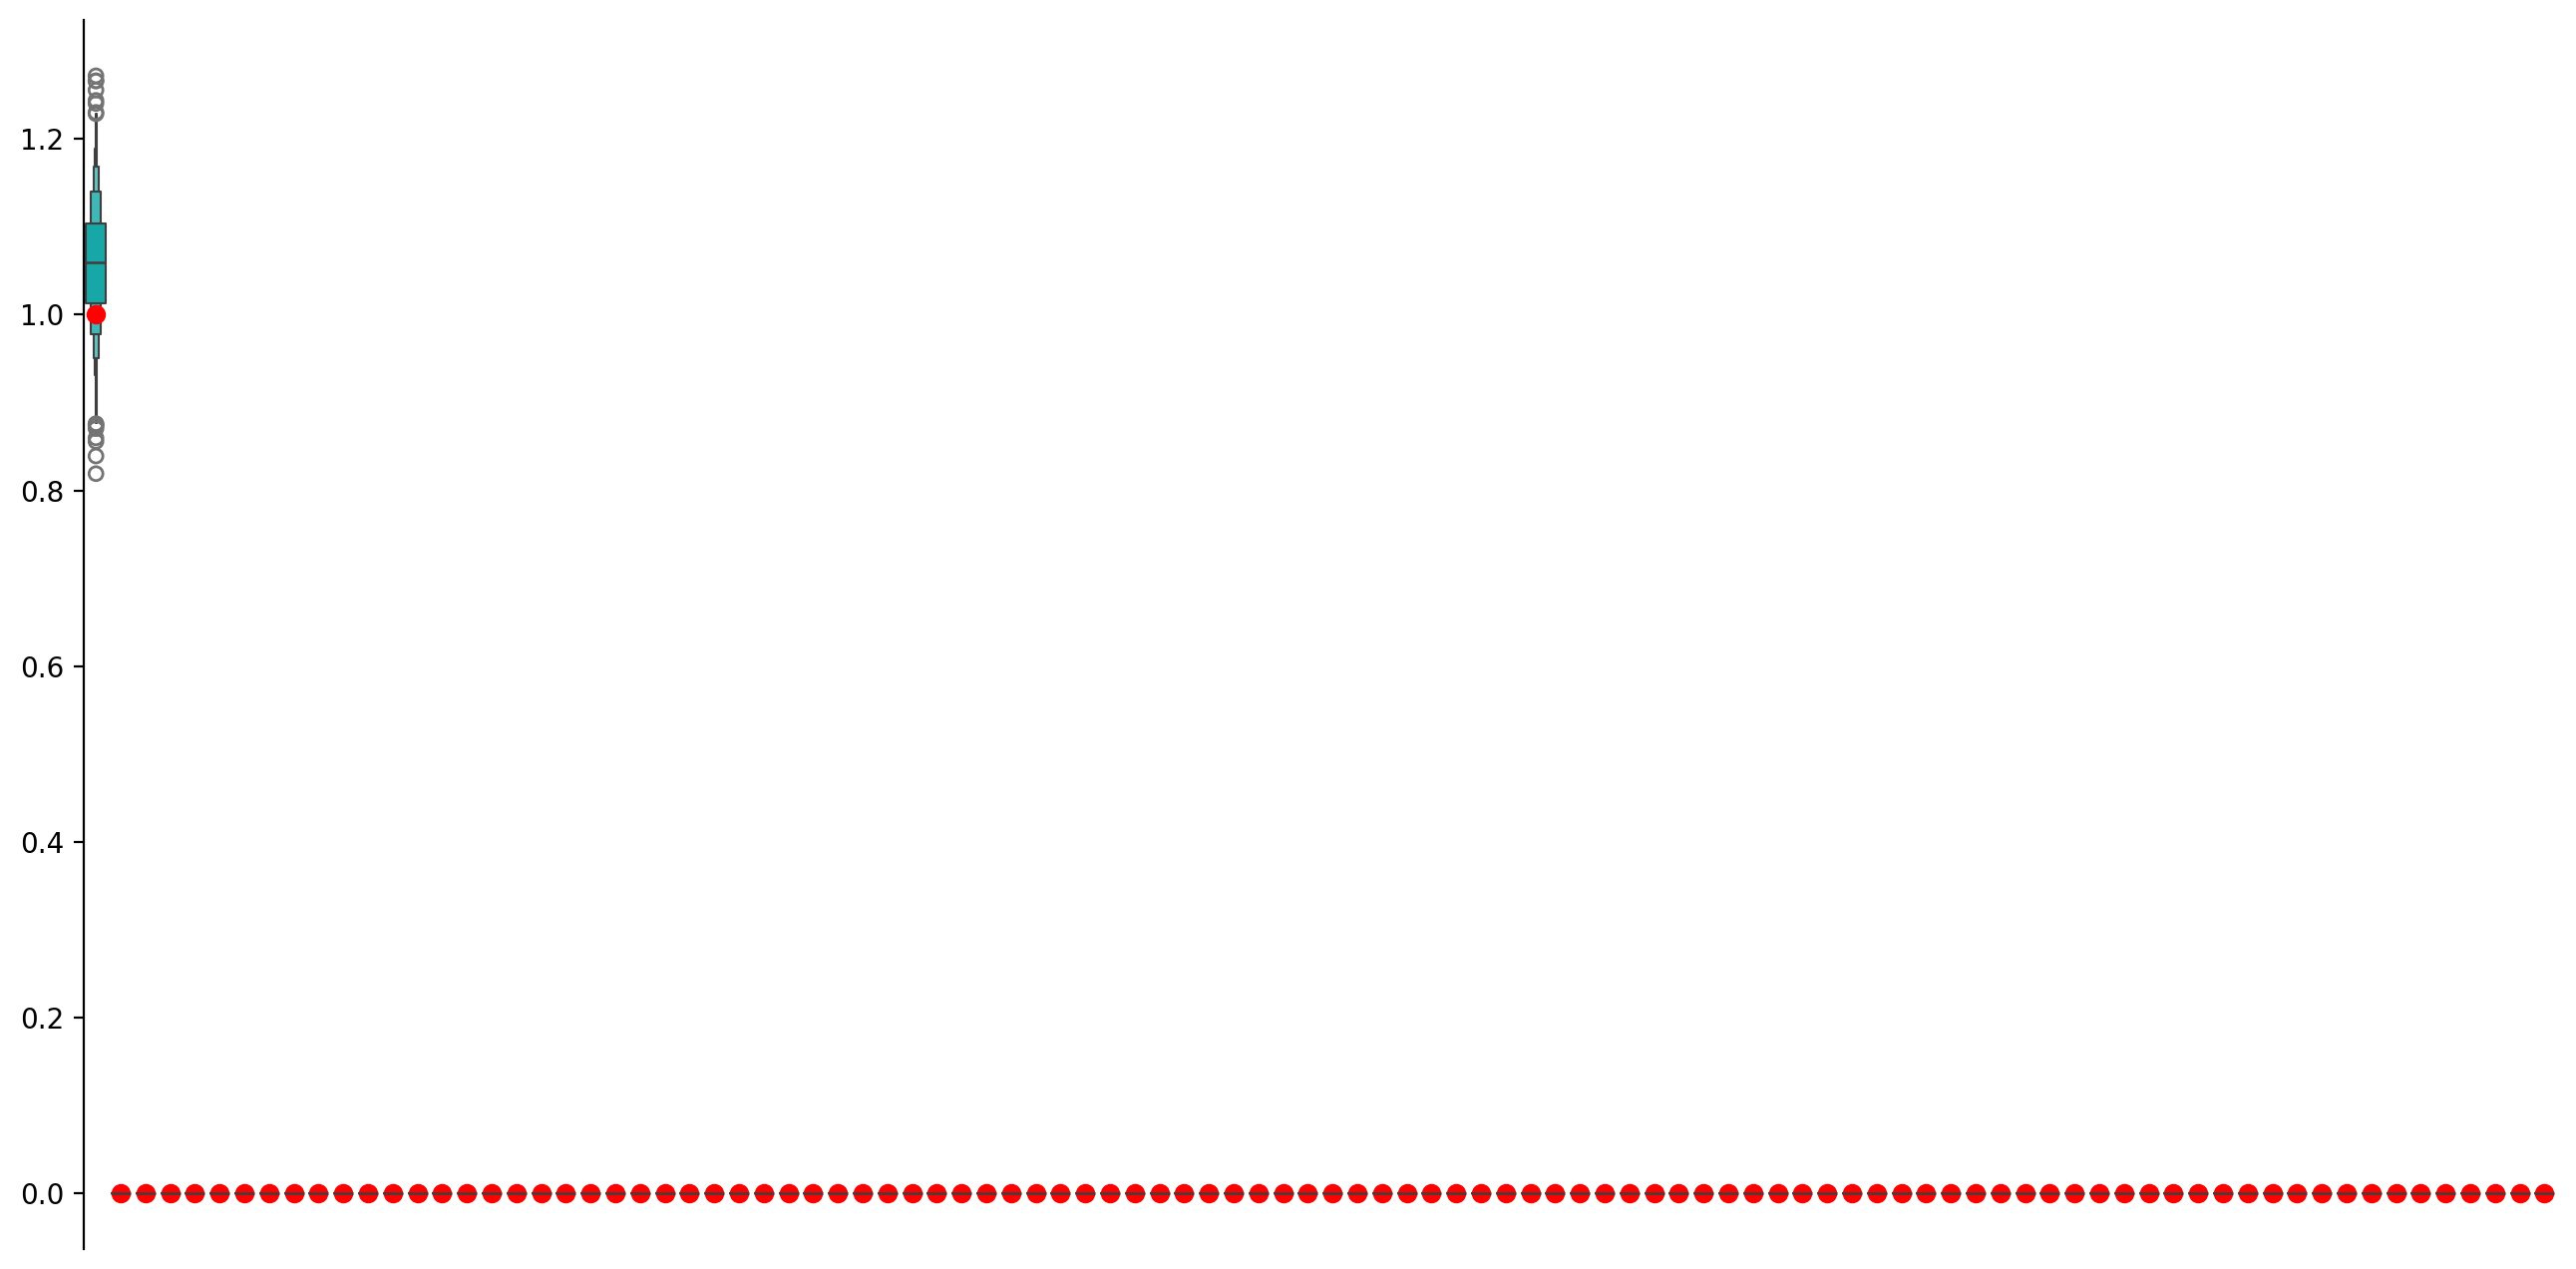

In [14]:
_, mu_t, P_t, b_t = ΔF_mv(mu=mu_n, P=P_n, gamma_sqr=g_sqr, a=a_n, b=b_n)

idx = g_sqr > 0
L_n = jnp.linalg.cholesky(jnp.linalg.inv(P_t[idx][:, idx]))

rng_key, _rng_key = jr.split(rng_key)
sigma_square = dist.InverseGamma(a_n, b_t).sample(_rng_key, sample_shape=(1000,))

rng_key, _rng_key = jr.split(rng_key)
eps = jr.normal(_rng_key, shape=(1000, idx.sum())) * jnp.expand_dims(jnp.sqrt(sigma_square), -1)
betas = mu_t[idx] + (L_n @ eps.T).T

_b = jnp.zeros((1000, D))

plt.figure(figsize=(16, 8))
plt.plot(nn.one_hot(0, num_classes=D), 'ro');
g = sns.boxenplot(_b.at[:, idx].set(betas), color='c')
g.tick_params(bottom=False);
g.set(xticklabels=[]);
sns.despine(bottom=True);